# Neural network for predicting the use of charging stations

This notebook describes the development and analysis of a neural network for predicting the hourly utilization of charging stations.

## Data preparation

The data is loaded from a CSV file and divided into training, validation and test data sets. The relevant input and target variables are:

- **Input variables:** `['hour_sin', 'hour_cos', 'is_holiday', 'is_weekend', 'is_vacation']`
- **Target variables:** `['activeSessions_site_1', 'activeSessions_site_2']`

In [2]:
import os
os.chdir(r'/')
print(os.getcwd())  # Verify the new working directory

C:\Users\chrii\PycharmProjects\AAEnergizer


In [9]:
import torch
import torch.nn as nn
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Dataset-Klasse ---
class PowerDataset(Dataset):
    def __init__(self, data, input_columns, target_columns, sequence_length, forecast_horizon):
        self.features = data[input_columns].values
        self.targets = data[target_columns].values
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon

    def __len__(self):
        return len(self.features) - self.sequence_length - self.forecast_horizon + 1

    def __getitem__(self, idx):
        x = self.features[idx: idx + self.sequence_length]
        y = self.targets[idx + self.sequence_length: idx + self.sequence_length + self.forecast_horizon]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# --- Daten laden ---
df = pd.read_csv("data/processed/hourly_avg_power_cut.csv")
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = len(df) - train_size - val_size

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

input_columns = ['hour_sin', 'hour_cos', 'is_holiday', 'is_weekend', 'is_vacation']
target_columns = ['activeSessions_site_1', 'activeSessions_site_2']

sequence_length = 24
forecast_horizon = 24

train_dataset = PowerDataset(train_df, input_columns, target_columns, sequence_length, forecast_horizon)
val_dataset = PowerDataset(val_df, input_columns, target_columns, sequence_length, forecast_horizon)
test_dataset = PowerDataset(test_df, input_columns, target_columns, sequence_length, forecast_horizon)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model architecture

The neural network is based on an LSTM model that is particularly suitable for sequential data. The architecture includes:

- **LSTM layer:** Extracts temporal features from the input sequences.
- **Fully Connected Layer:** Projection onto the target variables.

In [10]:
class UtilizationPredictor(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, output_size, forecast_horizon, learning_rate):
        super(UtilizationPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * forecast_horizon)
        self.criterion = nn.MSELoss()
        self.learning_rate = learning_rate
        self.forecast_horizon = forecast_horizon

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1, self.forecast_horizon, int(out.shape[1]/self.forecast_horizon))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

## Training

The model is trained with a training data set and monitors the validation errors during training. A ModelCheckpoint saves the best model based on the validation loss.

The hyperparameters are the follwing:
- **Input size:** Number of input features.
- **Hidden size:** Number of hidden units in the LSTM layer.
- **Number of layers:** Number of LSTM layers.
- **Output size:** Number of output features.
- **Forecast horizon:** Number of time steps to predict into the future.
- **Learning rate:** Learning rate for the optimizer.
- **Max epochs:** Maximum number of epochs for training.


In [11]:
if __name__ == '__main__':
    model = UtilizationPredictor(
        input_size=len(input_columns),
        hidden_size=128,
        num_layers=2,
        output_size=len(target_columns),
        forecast_horizon=forecast_horizon,
        learning_rate=0.001
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath="models",
        filename="utilization-predictor-{epoch:02d}-{val_loss:.4f}",
        save_top_k=1,
        mode="min"
    )

    trainer = pl.Trainer(
        max_epochs=300,
        log_every_n_steps=1,
        callbacks=[checkpoint_callback]
    )

    trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\chrii\PycharmProjects\AAEnergizer\.venv311\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: UserWarning:

Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

C:\Users\chrii\PycharmProjects\AAEnergizer\.venv311\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: UserWarning:

Checkpoint directory C:\Users\chrii\PycharmProjects\AAEnergizer\models exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params | Mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\chrii\PycharmProjects\AAEnergizer\.venv311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: PossibleUserWarning:

The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.

C:\Users\chrii\PycharmProjects\AAEnergizer\.venv311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: PossibleUserWarning:

The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Analysis and visualization

After training, the model is evaluated on the test data and the predictions are compared with the actual values. The following graphic shows the results for the "Active Sessions" at Site 1 and 2:

In [8]:
import torch
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from torch.utils.data import DataLoader

from src.models.lstm import input_columns
from src.models.lstm_24h_v2 import UtilizationPredictor, PowerDataset

def prepare_24h_batches(df, start_hour=4):
    """
    Teilt das Dataset in 24-Stunden-Abschnitte auf, beginnend bei `start_hour`.
    """
    df['hour_of_day'] = df['hour'].dt.hour
    start_indices = df[df['hour_of_day'] == start_hour].index

    batches = []
    for start_idx in start_indices:
        if start_idx + 24 <= len(df):
            batch = df.iloc[start_idx:start_idx + 24]
            batches.append(batch)

    return batches

def generate_plots_for_24h_predictions(
        ckpt_path: str,
        test_batches,
        target_columns,
        input_columns,
        device: str = "cpu"
):
    """
    Macht Vorhersagen für 24h-Batches und erstellt ein gemeinsames Diagramm.
    """
    # Modell vom Checkpoint laden
    model = UtilizationPredictor.load_from_checkpoint(ckpt_path)
    model.to(device)
    model.eval()

    # Initialisierung für alle Predictions und Stunden
    all_predictions = []
    all_actuals = []
    all_hours = []

    # Vorhersagen pro Batch
    with torch.no_grad():
        for batch in test_batches:
            # Daten vorbereiten
            input_data = batch[input_columns].values
            targets = batch[target_columns].values
            hours = batch["hour"].values

            # Batch in Tensor konvertieren
            input_tensor = torch.tensor(input_data, dtype=torch.float32).unsqueeze(0).to(device)
            target_tensor = torch.tensor(targets, dtype=torch.float32).unsqueeze(0).to(device)

            # Modellvorhersagen
            predictions = model(input_tensor).cpu().numpy()

            # Ergebnisse sammeln
            all_predictions.append(predictions[0])  # Batch (24, num_targets)
            all_actuals.append(targets)  # (24, num_targets)
            all_hours.append(hours)  # (24,)

    # DataFrames erstellen
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)
    all_hours = np.concatenate(all_hours, axis=0)

    # 24h Verschiebung umsetzen
    shifted_predictions = np.zeros_like(all_predictions)  # Initialisiere leeren Array
    shifted_predictions[24:] = all_predictions[:-24]      # Verschiebe um 24 Stunden

    col_pred = [f"pred_{col}" for col in target_columns]
    col_act = [f"actual_{col}" for col in target_columns]

    df_predictions = pd.DataFrame(shifted_predictions, columns=col_pred)
    df_actuals = pd.DataFrame(all_actuals, columns=col_act)
    df_combined = pd.concat([df_predictions, df_actuals], axis=1)
    df_combined['hour'] = all_hours

    #plot_active_sessions_site_1(df_combined)

    # Figure for active sessions on site 1
    fig = go.Figure()
    for col in ['activeSessions_site_1']:
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"pred_{col}"],
            mode="lines",
            name=f"Prediction: {col}"
        ))
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"actual_{col}"],
            mode="lines",
            name=f"Actual: {col}"
        ))

    fig.update_layout(
        title="24h Predictions vs. Actuals",
        xaxis_title="Hour",
        yaxis_title="Value",
        legend_title="Legend"
    )
    fig.show()

    # Figure for active sessions on site 2
    fig = go.Figure()
    for col in ['activeSessions_site_2']:
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"pred_{col}"],
            mode="lines",
            name=f"Prediction: {col}"
        ))
        fig.add_trace(go.Scatter(
            x=df_combined["hour"],
            y=df_combined[f"actual_{col}"],
            mode="lines",
            name=f"Actual: {col}"
        ))

    fig.update_layout(
        title="24h Predictions vs. Actuals",
        xaxis_title="Hour",
        yaxis_title="Value",
        legend_title="Legend"
    )
    fig.show()

    # Save the plot
    #fig.write_html("output/24h_predictions.html")

import matplotlib.pyplot as plt

# Function to create a non-interactive plot for active sessions on site 1
def plot_active_sessions_site_1(df_combined):
    # Extract active sessions data for site 1
    hours = df_combined["hour"]
    pred_active_sessions_site_1 = df_combined["pred_activeSessions_site_1"]
    actual_active_sessions_site_1 = df_combined["actual_activeSessions_site_1"]

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(hours, pred_active_sessions_site_1, label="Prediction: Active Sessions (Site 1)", linestyle='-')
    plt.plot(hours, actual_active_sessions_site_1, label="Actual: Active Sessions (Site 1)", linestyle='-')

    # Add labels and title
    plt.title("Active Sessions on Site 1: Predictions vs Actuals")
    plt.xlabel("Hour")
    plt.ylabel("Active Sessions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot as a PNG file
    plt.savefig("output/active_sessions_site_1.png")
    plt.show()

if __name__ == "__main__":
    # --- Parameter ---
    target_columns = [
        'activeSessions_site_1',
        'activeSessions_site_2'
    ]
    input_columns = ['hour_sin', 'hour_cos', 'is_holiday', 'is_weekend', 'is_vacation']
    dummies = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']
    input_columns += dummies
    sequence_length = 24

    # Testdaten laden
    df_test = pd.read_csv("data/processed/test_dataset_shifted.csv", parse_dates=["hour"])

    df_test[input_columns] = df_test[input_columns].astype('float32')
    df_test[target_columns] = df_test[target_columns].astype('float32')

    # 24h-Batches vorbereiten
    test_batches = prepare_24h_batches(df_test, start_hour=0)

    # Checkpoint-Pfad
    ckpt_path = "models/24h-model-epoch=277-val_loss=12.57438.ckpt"

    # Vorhersagen und Plot generieren
    generate_plots_for_24h_predictions(
        ckpt_path=ckpt_path,
        test_batches=test_batches,
        target_columns=target_columns,
        input_columns=input_columns,
        device="cpu"
    )


![Validation Loss](C:\Users\chrii\PycharmProjects\AAEnergizer\src\models\notebooks\val_loss.png)
# Some Metrics
The following visualization shows that both the training and validation loss steadily decrease over time, indicating consistent improvement. The training loss, however, fluctuates slightly more than the validation loss. By the end of the training, the validation loss stabilizes at approximately 12.5, suggesting that the model has effectively learned. The training process spanned a total of 300 epochs, and the validation loss curve implies that the model has likely reached convergence.








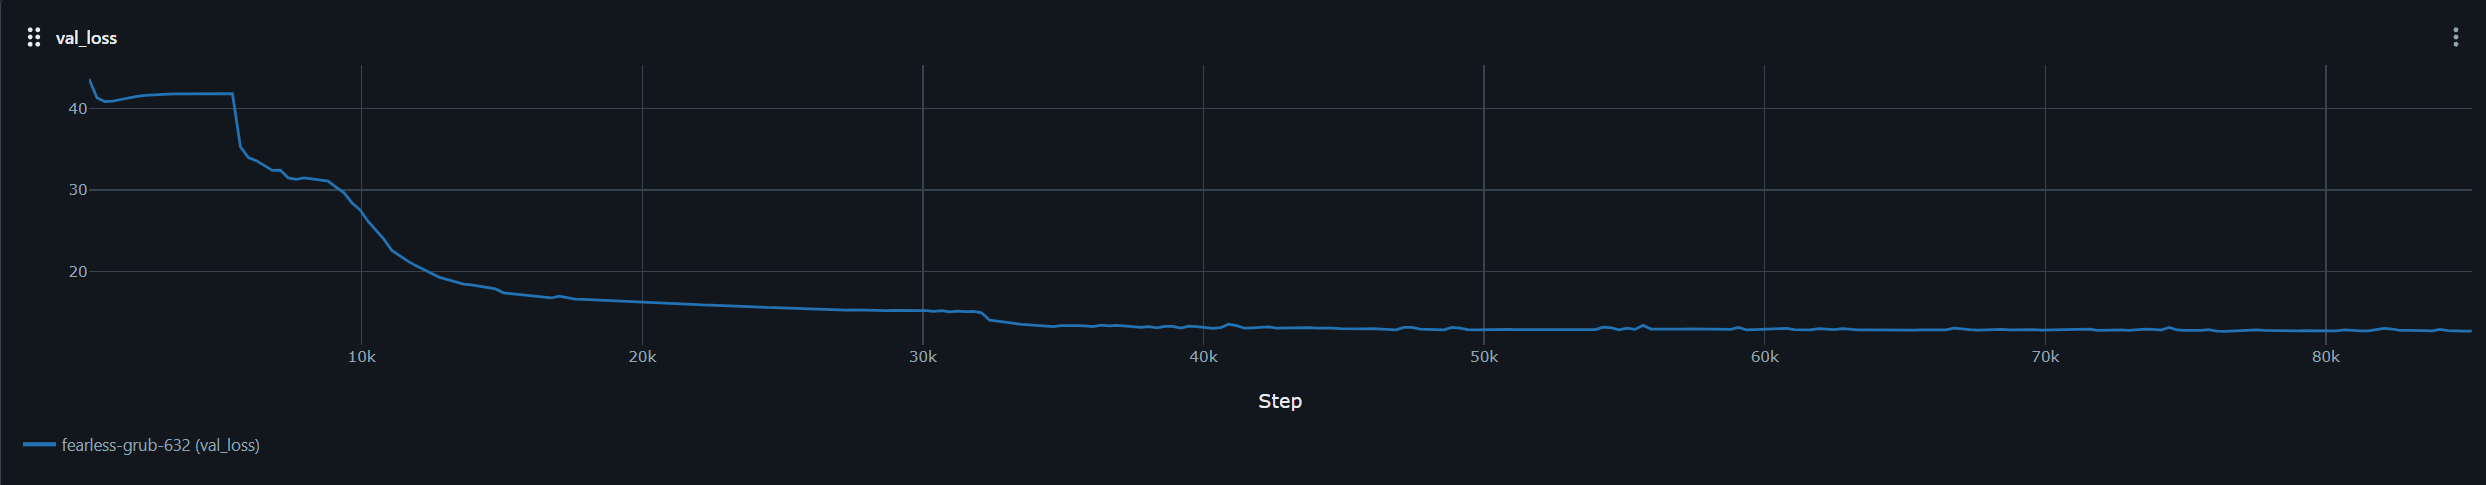

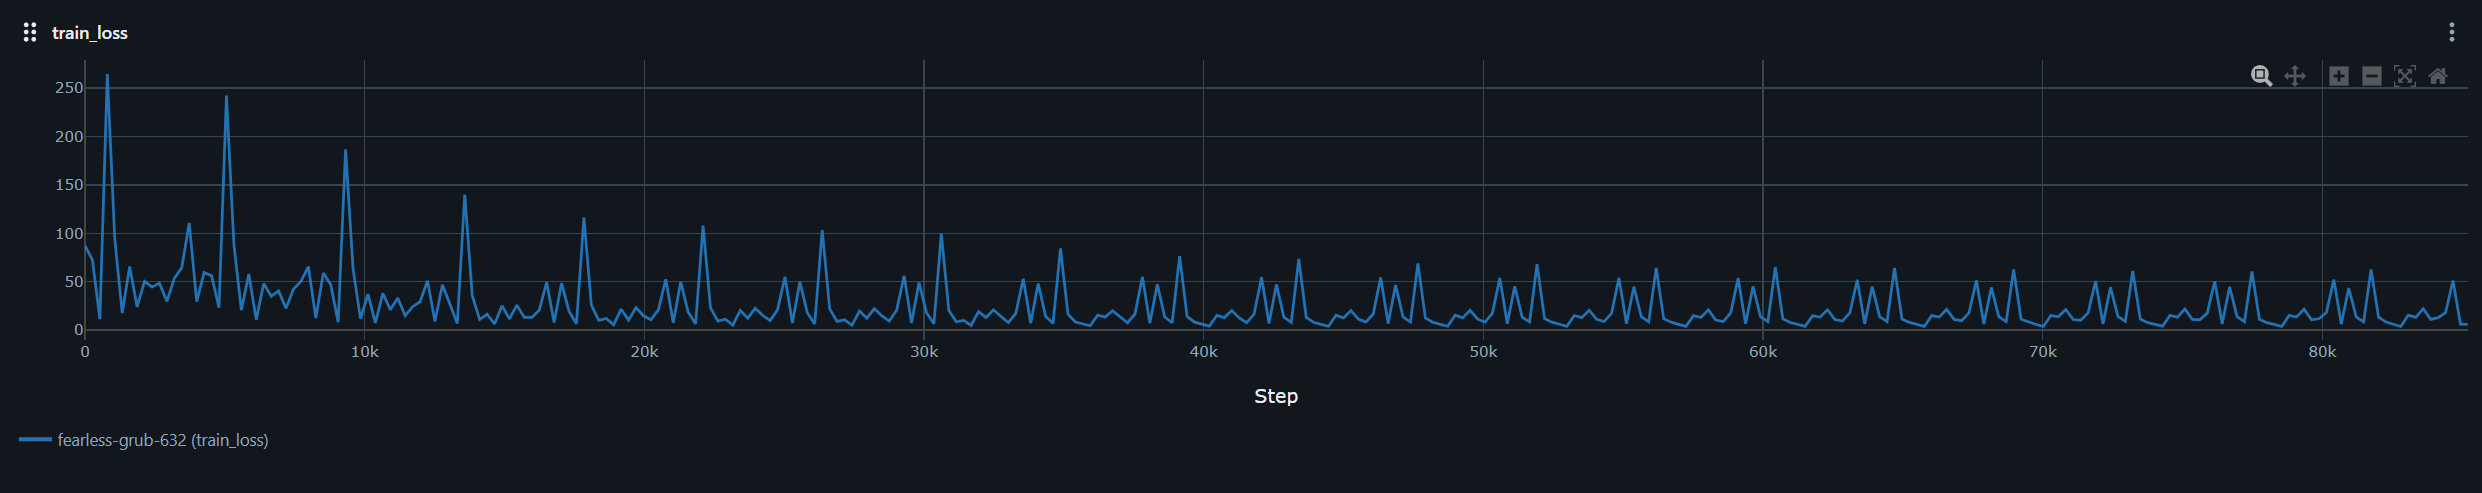

In [14]:
from IPython.display import Image, display

# Bild laden und anzeigen
image_path = "src/models/notebooks/val_loss.png"
display(Image(filename=image_path))
image_path_2 = "src/models/notebooks/train_loss.png"
display(Image(filename=image_path_2))